In [1]:
import numpy as np
from oe_acute import MNE
from oe_acute import trial_utils as tu
import os
import pickle
import glob

In [2]:
import numpy as np
from scipy.io.wavfile import read
from scipy import signal
from scipy.optimize import minimize
import glob
import os
import pickle
from oe_acute import trial_utils as tu
import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx

In [3]:
#exp_path = '/mnt/sphere/share/NCM_acute/experiments/B1596/block4/'
#sort_path =  '/mnt/sphere/share/NCM_acute/sorting/B1596/block4/'
exp_path = '/mnt/cube/mturvz/analysis/2019_08_16/sorted/201908170005-B1424-block-6-AP-2500-ML-500-Z-1500/2019-08-17_00-05-05/'
sort_path = '/mnt/cube/mturvz/analysis/2019_08_16/sorted/201908170005-B1424-block-6-AP-2500-ML-500-Z-1500/2019-08-17_00-05-05/'
#sort_path =  '/mnt/cube/srrudrar/sorted/B1692/block7/continuous/Rhythm_FPGA-100.0/'
stim_path = '/mnt/sphere/share/NCM_acute/MET_prediction_expt/'

ratings = [1,2,3]

ratings_str = ''.join([str(x) for x in ratings])

In [4]:
clusters = []
for rating in ratings:
    x = tu.get_clusters_by_rating(sort_path, rating)
    clusters.extend(x)

In [5]:
n_cells = len(clusters)

In [6]:
np.save('/mnt/cube/srrudrar/temporal_model/units_to_process_B1425_block6.npy', clusters)  

In [6]:
nperseg=128
noverlap=64
nfft=128
nsegbins=64
bp_low=300
bp_high=12000
bp_order=5
preemph_b=0.97
ref_level_dB=20
min_level_dB=-30

spec_all = []
stereo_all = []
stim_files = glob.glob(os.path.join(stim_path, '*.wav.sine'))

In [7]:
n_rows = 0
n_cols = 1
nsegbins = 64

In [8]:
### get stim and resp

In [10]:
import pickle as pkl
with open(os.path.join(exp_path, 'exp_dict.pkl'), 'rb') as f:
    exp_dict = pkl.load(f)

ValueError: unsupported pickle protocol: 5

In [10]:
stim_files = glob.glob(os.path.join(stim_path, '*.wav.sine'))
fs = exp_dict['fs']
n_channels = exp_dict['n_channels']
stim_names = exp_dict['stim_names']
stim_trials = exp_dict['stim_trials']

In [11]:
spike_times, spike_clusters = tu.get_spikes(sort_path)
window = (0, 0)
clusters = []
for rating in ratings:
    x = tu.get_clusters_by_rating(sort_path, rating)
    clusters.extend(x)

n_cells = len(clusters)

In [12]:
stim_preprocess_func = MNE.preprocess_wav_AVGN
avg_nrows = n_rows
avg_ncols = n_cols
avg_trials = True

In [13]:
stim_spec1 = []
#stim_resp1 = []
# for each stimulus
for stim_f in stim_files:
    #print(stim_f)
    stim_AVGN_spectrogram = stim_preprocess_func(stim_f)
    stim_spec1.append(stim_AVGN_spectrogram)

In [17]:
stim_spec_32 = []
for stim in stim_spec1:
    stim_32 = MNE.kozlov_averaging(stim, n_rows=1, n_cols=0)
    stim_spec_32.append(stim_32)

In [20]:
np.shape(stim_spec_32[10])

(32, 1369)

Text(0.5, 1.05, 'Mel Spectrogram')

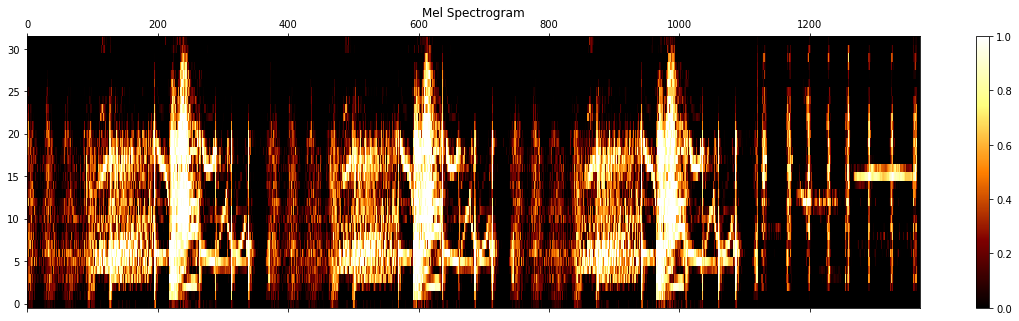

In [24]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,5))
cax = ax.matshow(stim_spec_32[10], interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Mel Spectrogram')

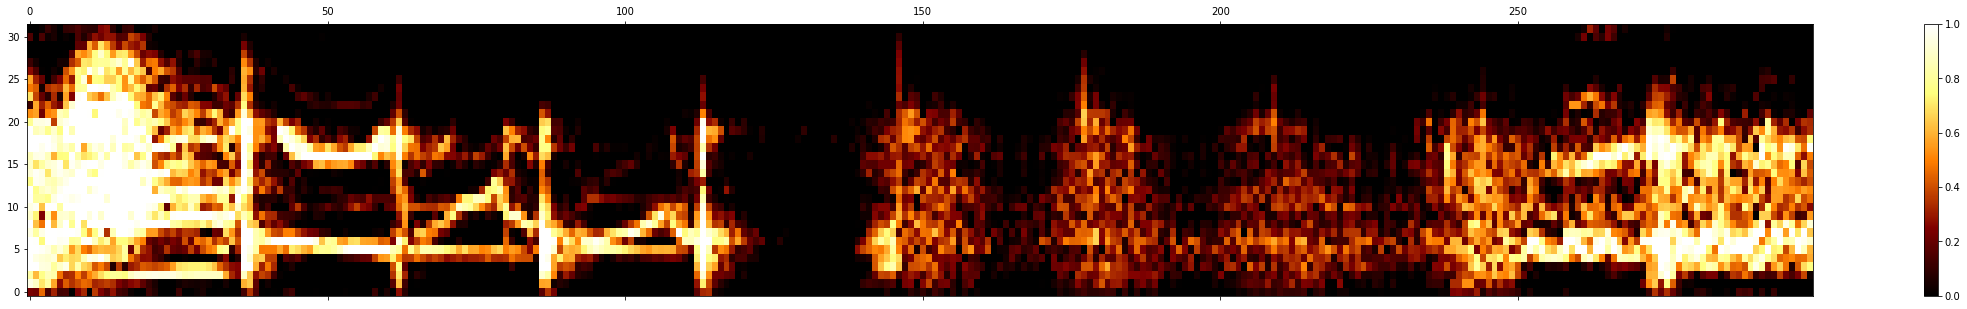

In [45]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(40,5))
cax = ax.matshow(stim_spec_32[10][:,600:900], interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
#plt.yticks([0, 3, 6, 9, 12])

#plt.savefig("/mnt/cube/srrudrar/paper1/figures/figure1_pc_nn_arch/spec.svg")

In [28]:
from scipy.io import wavfile
samplerate, data = wavfile.read(stim_files[10])

In [33]:
import wave
import contextlib
fname = stim_files[10]
with contextlib.closing(wave.open(fname,'r')) as f:
    frames = f.getnframes()
    rate = f.getframerate()
    duration = frames / float(rate)
    print(duration)

3.653605442176871


In [38]:
frames/np.shape(stim_spec_32[10])[1]*600, frames/np.shape(stim_spec_32[10])[1]*900

(70616.80058436815, 105925.20087655223)

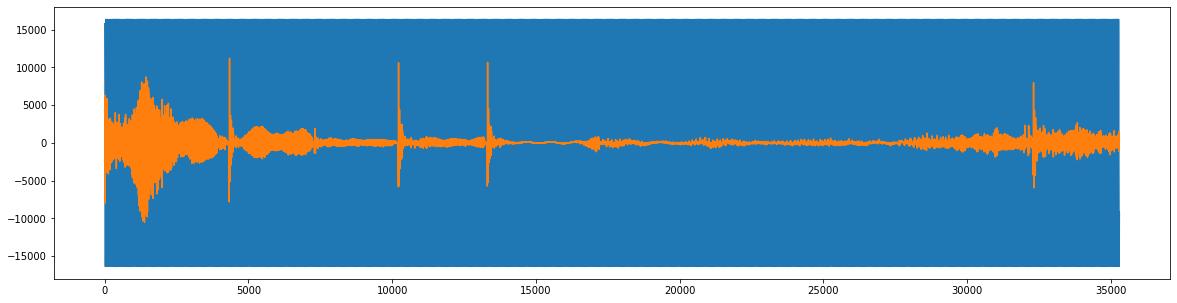

In [41]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,5))
ax.plot(data[70617:105925])

In [15]:
stim_spec1 = []
stim_resp1 = []
# for each stimulus
for stim_f in stim_files:
    #print(stim_f)

    stim_AVGN_spectrogram = stim_preprocess_func(stim_f)

    stim_name = os.path.split(stim_f)[-1]
    stim_name = stim_name.split('.')[0]
    print(stim_name)

    n_bins = stim_AVGN_spectrogram.shape[1]
    stim_len = stim_trials[stim_name]['n_samps']
    n_trials = stim_trials[stim_name]['trials'].shape[0]

    if avg_trials:
        stim_response_mtx = np.zeros((n_cells, n_bins))
    else:
        stim_response_mtx = np.zeros((n_cells, n_bins, n_trials), dtype=np.uint16)

    # Go through each unit collecting its mean spike count
    for unit_idx, unit in enumerate(sorted(clusters)):

        unit_trial_spikes = tu.get_unit_stim_spike_train(stim_trials[stim_name]['trials'], spike_times,
                                                         spike_clusters, unit, window, fs)
        binned_spikes = MNE.bin_trial_spikes(unit_trial_spikes, stim_len, n_bins)
        if avg_trials:
            mean_spike_count = np.mean(binned_spikes, axis=0)
            stim_response_mtx[unit_idx, :] = mean_spike_count
        else:
            stim_response_mtx[unit_idx, :, :] = binned_spikes.T

    stim_AVGN_spectrogram = MNE.kozlov_averaging(stim_AVGN_spectrogram, n_rows=avg_nrows, n_cols=avg_ncols)
    stim_response_mtx = MNE.kozlov_averaging(stim_response_mtx, n_rows=0, n_cols=avg_ncols) # only average response overt time bins\

    print(np.shape(stim_AVGN_spectrogram)[1] - 64)
    stim_spec1.append(stim_AVGN_spectrogram)
    stim_resp1.append(stim_response_mtx)

3_E6211_s_13@1___E6211_s_13@1
666
2_A62165_s_62@1___B_G105_s_03_@1
320
3_Y1_G105_s_02_@2___Y1_G105_s_02_@2
217
3_aa_G105_s_08_@2___aa_G105_s_08_@2
495
3_Q6211_s_29@1___Q2211_s_05@2
729
4_R1211_s_16@2___Q6211_s_29@1
805
2_E6165_s_12@2___E6165_s_12@2
355
4_C29165_s_29@1___C29165_s_29@1
686
4_B8165_s_26@1___B6211_s_08@1
834
3_ff1_G105_s_06_@1___ff1_G105_s_06_@1
1137
3_ee_G105_s_05_@2___F2165_s_06@2
620
3_aa_G105_s_08_@2___A62165_s_62@1
478
2_N_G105_s_04_@2___N1211_s_04@1
439
4_O2165_s_18@2___P_G105_s_07_@1
570
rmp5ms_181-15
11271
4_B22165_s_22@2___B12165_s_48@1
369
4_B22211_s_59@1___B22211_s_59@1
1180
4_I1211_s_04@1___I1211_s_04@1
870
5_P2165_s_16@1___P6211_s_52@1
888
4_Z3165_s_09@1___Z3165_s_09@1
420
3_F1211_s_04@2___F1211_s_04@2
686
2_N_G105_s_04_@2___M2165_s_20@1
410
2_B18211_s_58@2___B22165_s_22@2
354
4_R_G105_s_06_@1___R_G105_s_06_@1
657
3_L2_G105_s_01_@1___L6211_s_20@2
731
rmp5ms_G124-1
11110
2_A62165_s_62@1___Z24211_s_24@1
290
1_aa_G105_s_08_@2___B2165_s_03@3
252
2_K_G105_s_05_@1__

In [ ]:
#stim_spec1, stim_resp1 = MNE.prepare_stim_resp_dset(exp_path, sort_path, stim_path, stim_preprocess_func=MNE.preprocess_wav_AVGN, ratings=ratings, avg_nrows=n_rows, avg_ncols=n_cols)

In [17]:
type(stim_spec1), type(stim_resp1)

(list, list)

In [19]:
dsegs, spec1 = MNE.prepare_temporal_dset(stim_spec1, stim_resp1, nsegbins=nsegbins, thresh=0.01)

Final shape: (114137, 189, 64)
Next shape: (114137, 189)


In [20]:
### Reduce to 32 bins

In [18]:
np.shape(stim_spec1[0]), np.shape(stim_resp1[0])

((64, 730), (125, 730))

In [21]:
stim_spec_32 = []
for stim in stim_spec1:
    stim_32 = MNE.kozlov_averaging(stim, n_rows=1, n_cols=0)
    stim_spec_32.append(stim_32)

In [22]:
nsegbins1 = 32

In [24]:
dsegs_32, spec1_32 = MNE.prepare_temporal_dset(stim_spec_32, stim_resp1, nsegbins=nsegbins1, thresh=0.01)

Final shape: (108570, 157, 32)
Next shape: (108570, 157)


In [25]:
bird = 'B1425'

In [27]:
#spec_next_name = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/next_list_{}_32.pkl'.format(bird,bird)
#with open(spec_next_name, 'wb') as f:
#    pickle.dump(spec1_32, f)

spec_segs_name = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/segs_list_{}_32_part1.pkl'.format(bird,bird)
with open(spec_segs_name, 'wb') as f:
    pickle.dump(dsegs_32[:50000,:,:], f)
    
spec_segs_name = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/segs_list_{}_32_part2.pkl'.format(bird,bird)
with open(spec_segs_name, 'wb') as f:
    pickle.dump(dsegs_32[50000:,:,:], f)

In [6]:
#spec_f1 = '/mnt/cube/srrudrar/sorted/B1692/block7/stims-responses_B1692_block-7_2021-11-03.pkl'
#with open(spec_f1, 'rb') as f:
#    stim_resp_1 = pickle.load(f)
    
spec_f2 = '/mnt/cube/srrudrar/sorted/B1692/block7/stims-responses_B1692_block-7_2021-11-08.pkl'
with open(spec_f2, 'rb') as f:
    stim_resp_2 = pickle.load(f)

In [ ]:
#print(stim_resp_2['stim_names'])

In [ ]:
#np.shape(np.mean(stim_resp_2['stim_responses'][0], axis=2))

In [7]:
stim_resp_64 = [np.mean(i, axis=2) for i in stim_resp_2['stim_responses']]
stim_spec_64 = stim_resp_2['stim_spectrograms']

In [8]:
np.shape(stim_spec_64[0]), np.shape(stim_resp_64[0]), len(stim_spec_64)

((64, 633), (194, 633), 61)

In [ ]:
np.max(stim_spec_64[0]), np.min(stim_spec_64[0])

In [9]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [10]:
stim_spec_64_scaled = [normalize_data(s) for s in stim_spec_64]

In [ ]:
spec_f = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1692/stim_spec_B1692.pkl'
with open(spec_f, 'wb') as f:
    pickle.dump(stim_spec_64_scaled, f)

resp_f = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1692/stim_resp_B1692.pkl'
with open(resp_f, 'wb') as f:
    pickle.dump(stim_resp_64, f)

### reduce to 32 bins

In [11]:
stim_spec_32 = []
for stim in stim_spec_64_scaled:
    stim_32 = MNE.kozlov_averaging(stim, n_rows=1, n_cols=0)
    stim_spec_32.append(stim_32)

In [12]:
np.shape(stim_spec_32[0])

(32, 633)

In [13]:
nsegbins1 = 32

In [15]:
dsegs_64, spec1_64 = MNE.prepare_temporal_dset(stim_spec_64_scaled, stim_resp_64, nsegbins=64, thresh=0.01)

Final shape: (270717, 258, 64)
Next shape: (270717, 258)


In [14]:
dsegs_32, spec1_32 = MNE.prepare_temporal_dset(stim_spec_32, stim_resp_64, nsegbins=nsegbins1, thresh=0.01)

Final shape: (270749, 226, 32)
Next shape: (270749, 226)


In [ ]:
spec_segs_name1 = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1692/segs_list_B1692_32_part1.pkl'
with open(spec_segs_name1, 'wb') as f:
    pickle.dump(dsegs_32[:50000,:,:], f)
    
spec_segs_name2 = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1692/segs_list_B1692_32_part2.pkl'
with open(spec_segs_name2, 'wb') as f:
    pickle.dump(dsegs_32[50000:100000,:,:], f)
    
spec_segs_name3 = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1692/segs_list_B1692_32_part3.pkl'
with open(spec_segs_name3, 'wb') as f:
    pickle.dump(dsegs_32[100000:150000,:,:], f)
    
spec_segs_name4 = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1692/segs_list_B1692_32_part4.pkl'
with open(spec_segs_name4, 'wb') as f:
    pickle.dump(dsegs_32[150000:200000,:,:], f)
    
spec_segs_name5 = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1692/segs_list_B1692_32_part5.pkl'
with open(spec_segs_name5, 'wb') as f:
    pickle.dump(dsegs_32[200000:,:,:], f)

In [ ]:
spec_next_name = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1692/next_list_B1692_32.pkl'
with open(spec_next_name, 'wb') as f:
    pickle.dump(spec1_32, f)

In [ ]:
np.shape(dsegs_32), np.shape(spec1_32)

In [ ]:
#dsegs_1596 = pickle.load(open('/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1596/segs_list_B1596_32_part1.pkl'))

segs_f1 = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1596/segs_list_B1596_32_part1.pkl'
with open(segs_f1, 'rb') as f:
    dsegs_1596 = pickle.load(f)

next_f = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1596/next_list_B1596_32.pkl'
with open(next_f, 'rb') as f:
    spec1_1596 = pickle.load(f)

In [ ]:
np.shape(dsegs_1596), np.shape(spec1_1596)

In [ ]:
dsegs_1692 = dsegs_32[:, :32, :]
next_1692 = spec1_32[:, :32]
dsegs_1596_1 = dsegs_1596[:, :32, :]
next_1596 = spec1_1596[:, :32]

In [ ]:
np.max(dsegs_1692[0]), np.max(dsegs_1596_1[0]), np.min(dsegs_1692[0]), np.min(dsegs_1596_1[0])

### Load stim_spec, stim_resp

In [ ]:
spec_f = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/stim_spec_B1596.pkl'
with open(spec_f, 'wb') as f:
    pickle.dump(stim_spec1, f)

resp_f = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/stim_resp_B1596.pkl'
with open(resp_f, 'wb') as f:
    pickle.dump(stim_resp1, f)

In [ ]:
spec_f = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/stim_spec_B1596.pkl'
with open(spec_f, 'rb') as f:
    stim_spec = pickle.load(f)

resp_f = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/stim_resp_B1596.pkl'
with open(resp_f, 'rb') as f:
    stim_resp = pickle.load(f)

In [ ]:
type(stim_spec), type(stim_resp)

In [ ]:
#dset_segs = MNE.prepare_AE_dset(stim_spec, stim_resp, nsegbins=nsegbins, thresh=0.01)

In [ ]:
dsegs, spec1 = MNE.prepare_temporal_dset(stim_spec, stim_resp, nsegbins=nsegbins, thresh=0.01)

In [ ]:
Final shape: (60429, 278, 64)
Next shape: (60429, 278)

### Reduce to 16 bins

In [ ]:
np.shape(stim_spec[0]), np.shape(stim_resp[0])

In [ ]:
stim_spec_32 = []
for stim in stim_spec:
    stim_32 = MNE.kozlov_averaging(stim, n_rows=1, n_cols=0)
    stim_spec_32.append(stim_32)

In [ ]:
nsegbins1 = 32

In [ ]:
dsegs_32, spec1_32 = MNE.prepare_temporal_dset(stim_spec_32, stim_resp, nsegbins=nsegbins1, thresh=0.01)

In [ ]:
spec_next_name = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/next_list_B1596_32.pkl'
with open(spec_next_name, 'wb') as f:
    pickle.dump(spec1_32, f)

In [ ]:
dsegs_32_part1 = dsegs_32[:50000,:,:]
dsegs_32_part2 = dsegs_32[50000:,:,:]

In [ ]:
spec_segs_name = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/segs_list_B1596_32_part1.pkl'
with open(spec_segs_name, 'wb') as f:
    pickle.dump(dsegs_32_part1, f)

In [ ]:
spec_segs_name = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/segs_list_B1596_32_part2.pkl'
with open(spec_segs_name, 'wb') as f:
    pickle.dump(dsegs_32_part2, f)